In [ ]:
!pip install box2d

In [63]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [64]:
from pathlib import Path
import imageio
from IPython.display import HTML, display
import gymnasium as gym
import time

def visualize(gif_path="lunar_lander_wm.gif", model=None):
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    frames = []

    obs, _ = env.reset()
    terminated = False
    truncated = False

    while not (terminated or truncated):
        if model is None:
            action = env.action_space.sample()
        # --- Вариант 2: StableBaselines3 ---
        elif hasattr(model, "predict"):
            action, _ = model.predict(obs, deterministic=True)

        # --- Вариант 3: PyTorch DQN ---
        else:
            with torch.no_grad():
                device = next(model.parameters()).device
                state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                q_values = model(state)
                action = int(torch.argmax(q_values, dim=1).item())
                
        obs, _, terminated, truncated, _ = env.step(action)

        frame = env.render()
        frames.append(frame)

    env.close()

    # GIF
    with imageio.get_writer(gif_path, mode="I", duration=0.05) as writer:
        for frame in frames:
            writer.append_data(frame)

    # Уникальный query параметр для браузера
    cache_buster = time.time()
    display(HTML(f'<img src="{gif_path}?v={cache_buster}">'))

# Random Policy

In [45]:
# Использование
visualize(gif_path='lunar_lander_random.gif')

# StableBaselines3

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 78.5     |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1477     |
|    time_elapsed     | 0        |
|    total_timesteps  | 314      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 3.89     |
|    n_updates        | 53       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.5     |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1320     |
|    time_elapsed     | 0        |
|    total_timesteps  | 764      |
| train/              |       

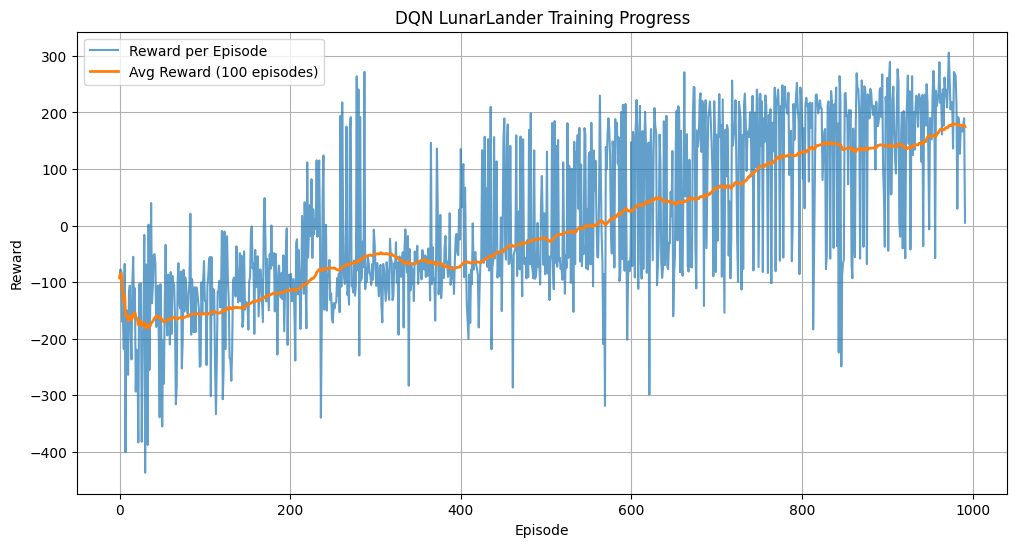

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback


# ====== Кастомный callback для логирования ======
class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.smoothed_rewards = []
        self.current_rewards = 0.0

    def _on_step(self) -> bool:
        # SB3 хранит done флаг в info["terminal_observation"] в новых версиях Gymnasium
        infos = self.locals.get("infos", [])
        for info in infos:
            # Если эпизод завершён
            if "episode" in info:
                r = info["episode"]["r"]
                self.episode_rewards.append(r)

                # Последние 100 эпизодов
                if len(self.episode_rewards) >= 100:
                    avg100 = np.mean(self.episode_rewards[-100:])
                else:
                    avg100 = np.mean(self.episode_rewards)

                self.smoothed_rewards.append(avg100)

        return True


# ====== Создание окружения ======
env = gym.make("LunarLander-v3", render_mode="rgb_array")

# ====== Создание модели ======
callback = RewardLoggerCallback()
model = DQN(
    "MlpPolicy", 
    env, 
    verbose=1,
    learning_rate=1e-3,
    batch_size=64,
    buffer_size=50_000
)

# ====== Обучение ======
model.learn(total_timesteps=500_000, callback=callback)
model.save("dqn_lunar")


# ====== Визуализация ======
plt.figure(figsize=(12, 6))
plt.plot(callback.episode_rewards, label="Reward per Episode", alpha=0.7)
plt.plot(callback.smoothed_rewards, label="Avg Reward (100 episodes)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN LunarLander Training Progress")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
from stable_baselines3 import DQN
model = DQN.load("dqn_lunar")

visualize(model= model,gif_path='lunar_lander_sb3.gif')

# Чистый pyTorch

In [51]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("LunarLander-v3", render_mode="rgb_array")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


In [52]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [53]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [57]:
BATCH_SIZE = 128
GAMMA = 0.99 # discount factor as mentioned in the previous section
EPS_START = 0.9 #starting value of epsilon
EPS_END = 0.01 #final value of epsilon
EPS_DECAY = 2500 # rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005 # update rate of the target network
LR = 3e-4 # learning rate
NUM_EPISODES = 300


n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_rewards = []  

            
def plot_rewards(show_result=False):    
    plt.figure(2)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Rewards - Result')
    else:
        plt.clf()
        plt.title('Rewards - Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total reward per episode')
    if len(rewards_t) > 0:
        # награда за эпизод
        plt.plot(rewards_t.numpy(), label="Reward per episode")
        # скользящее среднее по 100 эпизодам
        if len(rewards_t) >= 100:
            means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy(), label="100-episode mean")
        plt.legend()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [55]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)


    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)


    state_action_values = policy_net(state_batch).gather(1, action_batch)


    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize 
    optimizer.zero_grad()
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


<Figure size 640x480 with 0 Axes>

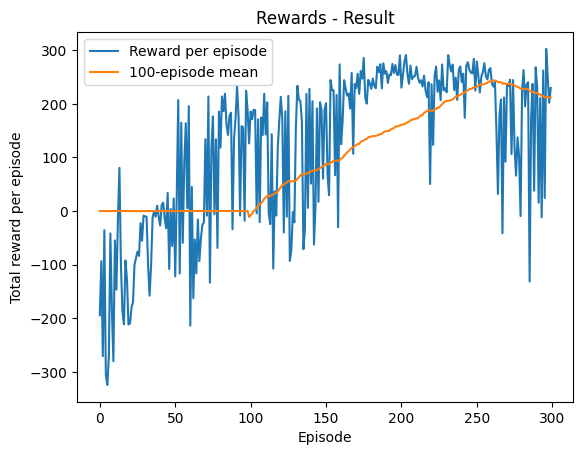

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [58]:
for i_episode in range(NUM_EPISODES):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0.0 
    
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        total_reward += reward
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(total_reward)
            plot_rewards()
            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [61]:
torch.save(target_net.state_dict(), 'torchDQN.pt')

In [65]:

target_net = DQN(n_observations=8,n_actions=4).to('cpu')
sd = torch.load(
    'torchDQN.pt',
    map_location='cpu',
    weights_only=True,
)
target_net.load_state_dict(sd);    
target_net.eval()
visualize(model=target_net,gif_path='lunar_lander_pytorch.gif')